# Transfer-learning with MobileNet

In [3]:
import tensorflow as tf
import PIL
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)

In [4]:
# Global Variables for locations of images etc
image_dir = "/Users/rmenon/Documents/Rex/Summer2020/Insight_Project/data/raw/home_images"
training_dir = "/Users/rmenon/Documents/Rex/Summer2020/Insight_Project/data/processed/home_images"

In [5]:
# This is specifically for loading images for mobilenet format
import numpy as np
def load_image(img_file, target_size=(224,224)):
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file, 
        target_size=target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

In [6]:
import os
def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [83]:
model = tf.keras.applications.mobilenet.MobileNet()
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [84]:
model = tf.keras.applications.mobilenet.MobileNet(
  input_shape=(224, 224, 3), 
  include_top=False, 
  pooling='avg'
)
model.dropout = 'drop'

In [85]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [86]:
# Adding additional layers
x = Dense(64)(model.output)
x = Dropout(rate=0.4)(x)
#x = Dropout(rate=0.4)(model.output)
x = Dense(7)(x)
x = Softmax()(x)
model= Model(model.inputs, x)

In [87]:
for layer in model.layers[:-4]:
#for layer in model.layers[:-3]:
    layer.trainable = False

In [88]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [93]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'AUC']
)

In [90]:
from tensorflow.keras.applications import mobilenet as _mobilenet

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=_mobilenet.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
    #rescale=1.0/255.0
    #featurewise_center = True,
    #featurewise_std_normalization = True
)

ensure_folder_exists(training_dir+'/training_aug')
training = datagen.flow_from_directory( 
    image_dir, 
    target_size=(224, 224),
    #save_to_dir=training_dir+'/training_aug',
    subset='training'
) 

ensure_folder_exists(training_dir+'/validation_aug')
validation = datagen.flow_from_directory( 
    image_dir,
    target_size=(224, 224),
    #save_to_dir=training_dir+'/validation_aug',
    subset='validation'
) 

Found 1668 images belonging to 7 classes.
Found 183 images belonging to 7 classes.


In [91]:
from keras_tqdm import TQDMNotebookCallback

In [94]:
from keras_tqdm import TQDMNotebookCallback
import time

batch_size = 64

start_time = time.time()
history = model.fit_generator(
    generator=training,
    steps_per_epoch=training.samples // batch_size,
    epochs=25,
    callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)],
    validation_data=validation,
    validation_steps=None
)
print('Number of minutes taken is %f'%(time.time()-start_time/60.0))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 26 steps, validate for 6 steps


Epoch 1/25
26/26 [==============================] - 32s 1s/step - loss: 0.5248 - accuracy: 0.8113 - AUC: 0.9766 - val_loss: 1.4444 - val_accuracy: 0.5355 - val_AUC: 0.8709


Epoch 2/25
26/26 [==============================] - 32s 1s/step - loss: 0.5699 - accuracy: 0.8047 - AUC: 0.9720 - val_loss: 1.4015 - val_accuracy: 0.5137 - val_AUC: 0.8746


Epoch 3/25
26/26 [==============================] - 30s 1s/step - loss: 0.5337 - accuracy: 0.8221 - AUC: 0.9746 - val_loss: 1.5225 - val_accuracy: 0.5628 - val_AUC: 0.8623


Epoch 4/25
26/26 [==============================] - 31s 1s/step - loss: 0.5434 - accuracy: 0.7993 - AUC: 0.9737 - val_loss: 1.3397 - val_accuracy: 0.5738 - val_AUC: 0.8818


Epoch 5/25
26/26 [==============================] - 30s 1s/step - loss: 0.5158 - accuracy: 0.8184 - AUC: 0.9763 - val_loss: 1.3063 - val_accuracy: 0.5792 - val_AUC: 0.8813


Epoch 6/25
26/26 [==============================] - 31s 1s/step - loss: 0.4863 - accuracy: 0.8221 - AUC: 0.9789 - val_loss: 1.4274 - val_accuracy: 0.5628 - val_AUC: 0.8724


Epoch 7/25
26/26 [==============================] - 30s 1s/step - loss: 0.5162 - accuracy: 0.7998 - AUC: 0.9761 - val_loss: 1.3611 - val_accuracy: 0.5410 - val_AUC: 0.8824


Epoch 8/25
26/26 [==============================] - 31s 1s/step - loss: 0.5211 - accuracy: 0.8233 - AUC: 0.9767 - val_loss: 1.5271 - val_accuracy: 0.5410 - val_AUC: 0.8614


Epoch 9/25
26/26 [==============================] - 31s 1s/step - loss: 0.5507 - accuracy: 0.8137 - AUC: 0.9732 - val_loss: 1.5057 - val_accuracy: 0.5246 - val_AUC: 0.8609


Epoch 10/25
26/26 [==============================] - 30s 1s/step - loss: 0.5620 - accuracy: 0.7774 - AUC: 0.9728 - val_loss: 1.3892 - val_accuracy: 0.5137 - val_AUC: 0.8741


Epoch 11/25
26/26 [==============================] - 31s 1s/step - loss: 0.4701 - accuracy: 0.8365 - AUC: 0.9805 - val_loss: 1.5051 - val_accuracy: 0.4863 - val_AUC: 0.8659


Epoch 12/25
26/26 [==============================] - 30s 1s/step - loss: 0.5091 - accuracy: 0.8072 - AUC: 0.9764 - val_loss: 1.4385 - val_accuracy: 0.5082 - val_AUC: 0.8690


Epoch 13/25
26/26 [==============================] - 31s 1s/step - loss: 0.5334 - accuracy: 0.7935 - AUC: 0.9748 - val_loss: 1.5511 - val_accuracy: 0.5301 - val_AUC: 0.8575


Epoch 14/25
26/26 [==============================] - 30s 1s/step - loss: 0.5142 - accuracy: 0.8134 - AUC: 0.9774 - val_loss: 1.3007 - val_accuracy: 0.5738 - val_AUC: 0.8870


Epoch 15/25
26/26 [==============================] - 30s 1s/step - loss: 0.4958 - accuracy: 0.8172 - AUC: 0.9783 - val_loss: 1.4442 - val_accuracy: 0.5301 - val_AUC: 0.8735


Epoch 16/25
26/26 [==============================] - 30s 1s/step - loss: 0.4772 - accuracy: 0.8284 - AUC: 0.9801 - val_loss: 1.5214 - val_accuracy: 0.5355 - val_AUC: 0.8644


Epoch 17/25
26/26 [==============================] - 31s 1s/step - loss: 0.4916 - accuracy: 0.8245 - AUC: 0.9791 - val_loss: 1.5253 - val_accuracy: 0.5082 - val_AUC: 0.8589


Epoch 18/25
26/26 [==============================] - 31s 1s/step - loss: 0.4677 - accuracy: 0.8462 - AUC: 0.9804 - val_loss: 1.3533 - val_accuracy: 0.5464 - val_AUC: 0.8781


Epoch 19/25
26/26 [==============================] - 32s 1s/step - loss: 0.5293 - accuracy: 0.8209 - AUC: 0.9744 - val_loss: 1.6141 - val_accuracy: 0.4754 - val_AUC: 0.8517


Epoch 20/25
26/26 [==============================] - 31s 1s/step - loss: 0.5136 - accuracy: 0.8284 - AUC: 0.9768 - val_loss: 1.3748 - val_accuracy: 0.5301 - val_AUC: 0.8761


Epoch 21/25
26/26 [==============================] - 31s 1s/step - loss: 0.4603 - accuracy: 0.8358 - AUC: 0.9812 - val_loss: 1.5333 - val_accuracy: 0.5301 - val_AUC: 0.8609


Epoch 22/25
26/26 [==============================] - 32s 1s/step - loss: 0.5060 - accuracy: 0.8109 - AUC: 0.9773 - val_loss: 1.5737 - val_accuracy: 0.4918 - val_AUC: 0.8582


Epoch 23/25
26/26 [==============================] - 31s 1s/step - loss: 0.4623 - accuracy: 0.8321 - AUC: 0.9818 - val_loss: 1.5100 - val_accuracy: 0.4973 - val_AUC: 0.8674


Epoch 24/25
26/26 [==============================] - 30s 1s/step - loss: 0.4624 - accuracy: 0.8371 - AUC: 0.9818 - val_loss: 1.4786 - val_accuracy: 0.5574 - val_AUC: 0.8688


Epoch 25/25
26/26 [==============================] - 30s 1s/step - loss: 0.4702 - accuracy: 0.8495 - AUC: 0.9794 - val_loss: 1.4726 - val_accuracy: 0.5301 - val_AUC: 0.8655



TypeError: unsupported operand type(s) for /: 'str' and 'int'

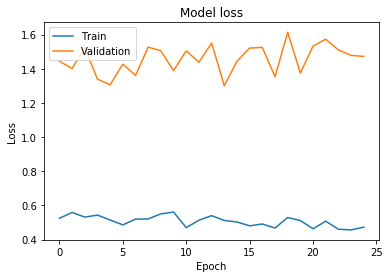

In [109]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

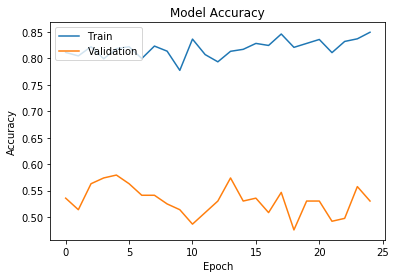

In [110]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [115]:
# Store model (in JSON) and weights (in h5py)
model_json = model.to_json()
with open("mobile_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights('mobile_model.h5')

In [125]:
house_type = '/tudor'
dir_name = image_dir+house_type
#dir_name = '/Users/rmenon/Documents/Rex/Summer2020/Insight_Project/data/raw/redfin_listings/98105_images'
house_image_id = os.listdir(dir_name)[0]
house_image = load_image(os.path.join(dir_name,house_image_id))
print(f'shape: {house_image.shape}')
print(f'type: {type(house_image)}')
np.shape(model.predict(house_image))

shape: (1, 224, 224, 3)
type: <class 'numpy.ndarray'>


(1, 7)

In [107]:
print('Number of minutes taken is %f'%(time.time()-start_time/60.0))

Number of minutes taken is 1564586560.803329


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


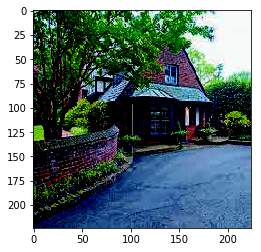

In [126]:
from matplotlib import pyplot as plt
plt.imshow(house_image[0,:,:,:])

In [127]:
model.predict(house_image)

array([[1.2879249e-01, 2.2476418e-02, 8.3899683e-01, 1.0875984e-04,
        2.9553758e-04, 4.6603242e-03, 4.6696733e-03]], dtype=float32)